In [ ]:
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

In [ ]:
model = Sequential()
#dw畳み込み
model.add(layers.SeparableConv2D(32,3,activation='relu',input_shape=(height,width,channels)))
model.add(layers.SeparableConv2D(64,3,activation='relu'))
model.add(layers.MaxPool2D(2))#pw畳み込み？

model.add(layers.SeparableConv2D(64,3,activation='relu'))
model.add(layers.SeparableConv2D(128,3,activation='relu'))
model.add(layers.MaxPool2D(2))#pw畳み込み？

model.add(layers.SeparableConv2D(64,3,activation='relu'))
model.add(layers.SeparableConv2D(128,3,activation='relu'))
model.add(layers.GlobalAveragePooling2D())#pw畳み込み？

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 11, 11, 64)       

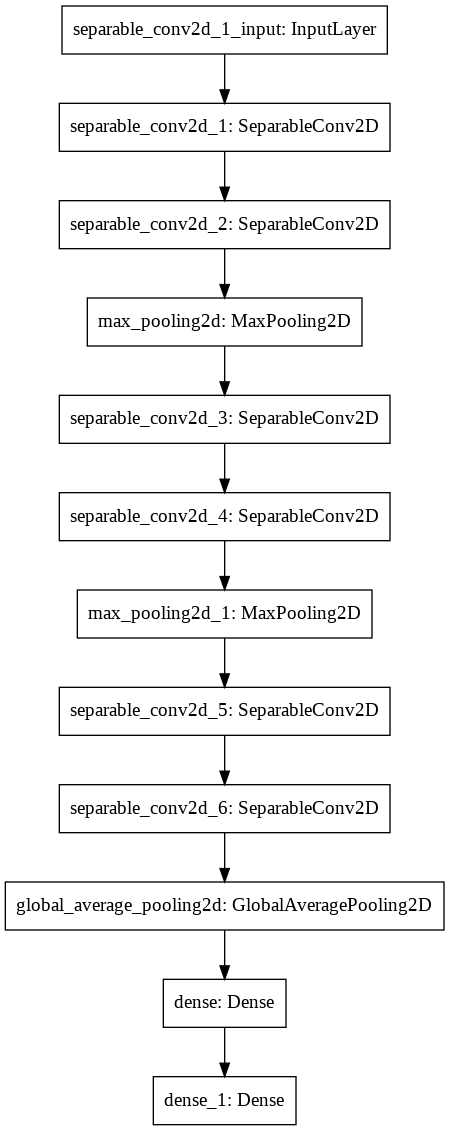

In [ ]:
#grahvis ライブライがひつよう

from keras.utils import plot_model
plot_model(model)#, to_file='model.png'

In [ ]:
モデルはアンサンブルされると性能が良くなる
どれだけ高性能でも単体より結果が良くなる

郡盲象を評す
盲じゃが集まれば象も言葉で表現できる

モデルが似た性能を持っている時に有効
一部のモデルが性能わるい場合、そこに平均値が引っ張られて逆に悪くなる
あとはモデルのpredictに重みをいくつかけてアンサンブルするかを決めるくらい
重みを学習させたりランダムサーチさせたりすることも良い。

アンサンブルによってデータを色々な方面から確認したモデルが最後に合わさることで性能を上げると考えられている。

よって、性能が似ているだけでなく、手法が異なるモデルを合わせたほうがいいわけです

DNNと木構造ベースなんかが良く見られます
あとはDeepとsharrowをアンサンブルさせたニューラルネットでしょう

構造が同じで初期重みだけ変えたネットワークのアンサンブルはよくならないでしょう



In [ ]:
文字を小文字にしてlstmで文字生成


In [ ]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

606208/600901 [==============================] - 0s 1us/step
Corpus length: 600893


In [ ]:
ワードを60文字刻みにしてひとつのシークエンスとして学習させる
サンプリングとして3単語？3文字?を送った後で再度60文字きざみ

最初と最後はかなり意味不明な文字列になるのでは？

In [ ]:
# Length of extracted character sequences
maxlen = 60
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


In [ ]:
次の文字を予測するlstm


In [ ]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
温度、とはsoftmax温度であり、シーケンスの傾向(次にくる文字の確率)を学習させたとき、
その確率のうち、いずれかにランダムな重みをかけること

この温度が極めて小さければ、softmaxの出力のうち最も大きい確率になる候補につながる
たまにこれでループすることもある

温度を大きく1に設定すると、選び方がかなりランダムになる。
ゆえに独創的な出力となる
今回は書き始め文字としてワードを渡している

エポックが増えればそれらしい文字を生成することになる

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1565/1565 [==============================] - 264s 168ms/step - loss: 1.9687
--- Generating with seed: " that they wish to get away therefrom. a little more
strengt"
------ temperature: 0.2
 that they wish to get away therefrom. a little more
strength and all the present all the pays of the fact and every and in the some of the relogical something and for the people of the faith in the peofle of the present and all the present and all the present and all the power the some and constation of the faith in it is the peofle of the for the power the power the people of the constance of the power the spire of the people of the people of all the pre
------ temperature: 0.5
e power the spire of the people of the people of all the present beer generary spirit is what the hisdountary of people exter to the more and counter
instance, and the somethings of the people at one of the beliety, in all the love foom a houds the corld and a conditional of the present somethings, all it is the fari

KeyboardInterrupt: ignored

In [ ]:
このようにして作ったモデルを
言語モデル
と呼ぶ

In [ ]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 87kB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 3.2MB 46.0MB/s 
     |████████████████████████████████| 491kB 38.1MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 9.2MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import tensorflow as tf

import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'2.0.8'

In [ ]:
deep dreamはCNNのフィルタ可視化と同じ

そのため、model zooからcnnアーキテクチャを選べばいいわけだが、
モデルはinceptionがそれらしい図を作ることが知られているのでこれを採用

In [ ]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

In [ ]:
勾配上昇法で使うのは損失値です
この損失値の最大化が目的なのです
以前フィルタ可視化のための損失最大化を説明しました
全てのフィルタの活性化を同時に最大化します

最大化するのはL2ノルムの荷重和です
層にどれだけ重みをかけるか設定します


In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [ ]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [ ]:
損失を定義

In [ ]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))

    #loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
勾配上昇法の実行

In [ ]:
import tensorflow as tf

In [ ]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [ ]:
元画像の情報にdreamを上書きするために、再注入します

小さい画像からdreamを書き、拡大していくのですが、拡大するたびに詳細の情報が抜け落ちるので、
詳細情報を元画像として再注入します
そしてまた拡大する

このdreamを上書きする部分をオクターブ(尺度)と呼びます
オクターブ間での拡大率が1.4という話。
オクターブを何ステップおくかも大切。細かくしたらしたほど明細になるだろう

In [ ]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = 'edit.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

FileNotFoundError: ignored

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


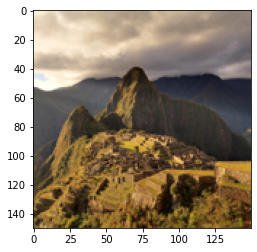

In [ ]:
from PIL import Image
from urllib import request
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/6/62/80_-_Machu_Picchu_-_Juin_2009_-_edit.jpg"
res = request.urlopen(url).read()
Sample_Image = Image.open(BytesIO(res)).resize((150,150))

plt.imshow(Sample_Image)

In [ ]:
img = np.asarray(Sample_Image)

In [ ]:
img.shape

(150, 150, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir()

['.config', 'drive', 'model.png', 'sample_data']

In [ ]:
os.listdir('drive')

['MyDrive', '.file-revisions-by-id', '.shortcut-targets-by-id', '.Trash']

In [ ]:
os.listdir('drive/My Drive')


['Colab Notebooks',
 'RasPy',
 'script',
 '給与明細',
 'Of2016.zip',
 '転職関係20190524',
 'T102HA',
 'omoide',
 'Rins.zip',
 '1119101100_zenbun.pdf',
 'JDLA合格',
 '39204.jpg',
 'ringa.jpg',
 'y-hiroshi(UMU表示名).ipynb',
 'day1演習_y-hiroshi(UMU表示名).ipynb',
 'day2演習_y-hiroshi(UMU表示名).ipynb',
 'day3演習_y-hiroshi(UMU表示名).ipynb',
 'day4演習_y-hiroshi(UMU表示名).ipynb',
 'day5演習_y-hiroshi(UMU表示名).ipynb',
 'day6演習_y-hiroshi(UMU表示名).ipynb',
 'y_hiroshi(UMU表示名).ipynb',
 'all_npy',
 'first-order-motion-model']

In [ ]:
base_image_path = 'model.png'
img = preprocess_image(base_image_path)

In [ ]:
img.shape

(1, 1131, 449, 3)

In [ ]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 2  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
#base_image_path = 'edit.jpg'
# Load the image into a Numpy array
#img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    #save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

#save_img(img, fname='final_dream.png')

Processing image shape (282, 112)
...Loss value at 0 : 0.4119745
...Loss value at 1 : 0.5306055
...Loss value at 2 : 0.7399616
...Loss value at 3 : 0.9902581
...Loss value at 4 : 1.2556112
...Loss value at 5 : 1.5253776
...Loss value at 6 : 1.8498925
...Loss value at 7 : 2.1499708
...Loss value at 8 : 2.4643877
...Loss value at 9 : 2.7797437
...Loss value at 10 : 3.0356417
...Loss value at 11 : 3.374302
...Loss value at 12 : 3.7400017
...Loss value at 13 : 4.087229
...Loss value at 14 : 4.4203944
...Loss value at 15 : 4.79273
...Loss value at 16 : 5.1142683
...Loss value at 17 : 5.4697237
...Loss value at 18 : 5.8019743
...Loss value at 19 : 6.224557
Processing image shape (565, 224)
...Loss value at 0 : 2.0766091
...Loss value at 1 : 3.5866597
...Loss value at 2 : 6.1593695
Processing image shape (1131, 449)
...Loss value at 0 : 4.806301
...Loss value at 1 : 9.953825


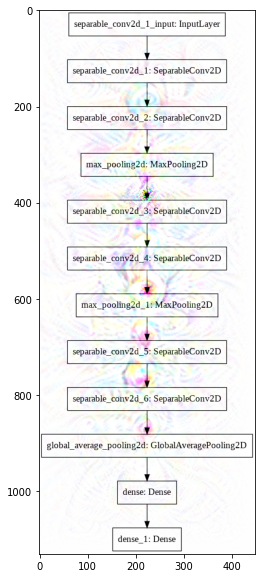

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(deprocess_image(np.copy(img)))
plt.show()

In [ ]:
deprocess_image(np.copy(img)).shape

(1131, 449, 3)

In [ ]:
インセプションが299*299のネットワークなので、よさげな結果は300~400の正方形あたりではないだろうかという話

In [ ]:
スタイル変換


In [ ]:
細かい構造はコンテンツとしてとらえ、色や流れ、線などの視覚パターンはスタイルと呼ぶことにする

いままでもスタイル変換に関する話はあったが、しかしdnnを使ったスタイル変換は目覚ましいものがあり、
gatyの発見も有名になった

スタイル画像(S)、コンテンツ画像(C)とそこから作られたジェネレート画像(G)があったとする

もし数値的にその性質が表されるのであれば、
style(S) - style(G) スタイルの保存が行われること
content(C) - content(G) コンテンツがなくならないこと
これらを足したものをlossとし、lossが最小になるように学習をすすめればいいことになる。

content,styleは、その性質を値とする計算が必要であるし、
単に引き算を行うよりも、距離を近づけるという意味で、L2距離を最小化することが一般的である


ここで、ネットワークについて考える
ネットワークとは、深くなるほど、出力に近づくほど、大域的で抽象的な情報を含むようになる
入力に近いほど、一部分の線などにこだわる

ここで、学習済ネットワークを用いて、出力側の層まで、生成画像(G)とコンテンツ画像(C)を流したとする
その時の層の活性化を似たものにすることで、大域的に似ている画像であることが保証される(だろう)　という考え方
もと論文では最終的な一つだけの大域的にとらえているだろう層を使いL2ノルムを最小化する



また、スタイルに関しては複数の層を使う
スタイルの損失には、L2でなくグラム行列を使っている
グラム行列は特徴マップ同士の内積であり、これを距離の基準としている。
内積とは距離であり相関である。
浅い層での特徴マップはスタイルを抽出している(という可視化からの仮定)ので
距離でなくこの損失をつかう
相関はテクスチャをまねる。


活性化を同様にするのがコンテンツ
活性化の相関関係を似た値にするのがスタイル






論文よりvgg19を使用
損失を定義する
その後、画像を400*400に整える行為をおこなうので、画像のピクセルが違う場合うまく再構成できないことに注意








In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = '/home/ubuntu/data/portrait.png'
# This is the path to the style image.
style_reference_image_path = '/home/ubuntu/data/popova.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [ ]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

In [ ]:
コンテンツ損失

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [ ]:
スタイル損失

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
総損失

In [ ]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [ ]:
最小化のための損失の式になおす

In [ ]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
損失と勾配を求める必要があり、別で計算すると時間が倍になるので、
どちらも同時にできるようにclassをつくり呼び出す

In [ ]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
スタイルを合わせに行くループ

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [ ]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()

In [ ]:
これはスタイルの相関が高く、
かつコンテンツが単純である場合にはうまくいく

信号処理的な考え方なので、
すべてのコンテンツ画像にうまく行くわけでもないし、
別人の顔に入れ替えるような抽象的な変換などもできないので注意